# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [1]:
!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet

import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# ✅ 使用统一的 lightning.pytorch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 101.3 MB/s eta 0:00:00


### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [ ]:
#NOTE Change the data directory according to where you have your zarr files stored
config = {
    "data": {
        "path": "/kaggle/input/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 64,
        "num_workers": 4,
    },
    "model": {
        "type": "simple_cnn",
        "kernel_size": 3,
        "init_dim": 64,
        "depth": 4,
        "dropout_rate": 0.1,
    },
    "training": {
        "lr": 5e-4,
    },
    "trainer": {
        "max_epochs": 80,
        "callbacks": [
            EarlyStopping(
                monitor="val/loss",
                patience=8,  
                mode="min",
                verbose=True
            ),
            ModelCheckpoint(
                monitor="val/loss",
                dirpath="checkpoints/",
                filename="model-{epoch:02d}-{val/loss:.4f}",
                save_top_k=1,  
                mode="min"
            )
        ],
        "logger": pl.loggers.TensorBoardLogger(save_dir="lightning_logs/"), 
        "log_every_n_steps": 50,  
        "enable_progress_bar": True,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 16,
        "deterministic": True,
        "num_sanity_val_steps": 0,
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

INFO: Seed set to 42


42

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [3]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**. 

We encourage you to build and experiment with your own models and ideas.


In [ ]:
import torch
import torch.nn as nn

# -----------------------------------------------
# SEBlock Module
# Inspired by design suggestions from ChatGPT (OpenAI), May 2025.
# Based on principles of Squeeze-and-Excitation networks (Hu et al., 2018).
# https://chat.openai.com/
# -----------------------------------------------

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.se(x)
        return x * scale

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool = torch.max(x, dim=1, keepdim=True)[0]
        x_cat = torch.cat([avg_pool, max_pool], dim=1)
        attn = torch.sigmoid(self.conv(x_cat))
        return x * attn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, use_se=True):
        super().__init__()
        self.use_se = use_se
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels)
            )
        if self.use_se:
            self.se = SEBlock(out_channels)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.use_se:
            out = self.se(out)
        out += self.skip(identity)
        return self.relu(out)

class SimpleCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=3, init_dim=64, depth=4, dropout_rate=0.2):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(init_dim),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.ModuleList()
        current_dim = init_dim
        for i in range(depth):
            out_dim = current_dim * 2 if i < depth - 1 else current_dim
            self.res_blocks.append(ResidualBlock(current_dim, out_dim))
            if i < depth - 1:
                current_dim *= 2

        self.attn = SpatialAttention()
        self.dropout = nn.Dropout2d(dropout_rate)
        self.final = nn.Sequential(
            nn.Conv2d(current_dim, current_dim // 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(current_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(current_dim // 2, n_output_channels, kernel_size=1),
        )

    def forward(self, x):
        x = self.initial(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        x = self.attn(x)
        return self.final(self.dropout(x))


### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [5]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [6]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        val_split=0.1,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [ ]:
import torch.optim as optim
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime
import os

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model'])
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []
        self.train_preds, self.train_targets = [], []  

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        # 记录训练集预测和真实值
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.train_preds.append(y_hat_np)
        self.train_targets.append(y_np)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def on_validation_epoch_end(self):
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        os.makedirs("val_outputs", exist_ok=True)
        np.save(f"val_outputs/val_preds_epoch{self.current_epoch}.npy", preds)
        np.save(f"val_outputs/val_trues_epoch{self.current_epoch}.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

        val_loss = self.trainer.callback_metrics.get("val/loss")
        print(f"[Epoch {self.current_epoch}] Validation Loss: {val_loss:.4f}")

        manual_mse = np.mean((preds - trues) ** 2)
        print(f"[Epoch {self.current_epoch}] Validation MSE (manual): {manual_mse:.4f}")

    def on_train_epoch_end(self):
        if len(self.train_preds) > 0:
            preds = np.concatenate(self.train_preds, axis=0)
            trues = np.concatenate(self.train_targets, axis=0)
            self._evaluate(preds, trues, phase="train")
            np.save(f"train_preds_epoch{self.current_epoch}.npy", preds)
            np.save(f"train_trues_epoch{self.current_epoch}.npy", trues)
            train_loss = np.mean((preds - trues) ** 2)
            print(f"[Epoch {self.current_epoch}] Train Loss (MSE): {train_loss:.4f}")
            self.train_preds.clear()
            self.train_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.hparams.learning_rate * 10,  
            total_steps=self.trainer.estimated_stepping_batches,  
            pct_start=0.3,  
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val/loss",  
                "interval": "step",  
            },
        }

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [8]:
datamodule = ClimateDataModule(**config["data"])
model = SimpleCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k != "type"}
)
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])

trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

/usr/local/lib/python3.10/dist-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loading `train_dataloader` to estimate number of stepping batches.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO: 
  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | model     | SimpleCNN | 10.8 M | train
1 | criterion | MSELoss   | 0      | train
------------------------------------------------
10.8 M    Trainable params
0         Non-trainable params
10.8 M    Total params
43.232    Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.9067, Time-Mean RMSE=7.2308, Time-Stddev MAE=2.4532
[VAL] pr: RMSE=3.3451, Time-Mean RMSE=1.8624, Time-Stddev MAE=1.7263
[Epoch 0] Validation Loss: 0.5618
[Epoch 0] Validation MSE (manual): 52.9186
[TRAIN] tas: RMSE=12.2290, Time-Mean RMSE=7.6085, Time-Stddev MAE=5.2899


INFO: Metric val/loss improved. New best score: 0.562


[TRAIN] pr: RMSE=3.7107, Time-Mean RMSE=1.9180, Time-Stddev MAE=1.3443
[Epoch 0] Train Loss (MSE): 96.1023


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.2485, Time-Mean RMSE=5.3379, Time-Stddev MAE=2.0950
[VAL] pr: RMSE=3.2131, Time-Mean RMSE=1.6320, Time-Stddev MAE=1.5667
[Epoch 1] Validation Loss: 0.4892
[Epoch 1] Validation MSE (manual): 37.9305
[TRAIN] tas: RMSE=8.0262, Time-Mean RMSE=5.5001, Time-Stddev MAE=2.5281


INFO: Metric val/loss improved by 0.073 >= min_delta = 0.0. New best score: 0.489


[TRAIN] pr: RMSE=3.1385, Time-Mean RMSE=1.6254, Time-Stddev MAE=1.4495
[Epoch 1] Train Loss (MSE): 43.8381


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.5504, Time-Mean RMSE=4.9549, Time-Stddev MAE=1.7872
[VAL] pr: RMSE=3.0582, Time-Mean RMSE=1.4442, Time-Stddev MAE=1.4870
[Epoch 2] Validation Loss: 0.4365
[Epoch 2] Validation MSE (manual): 33.0139
[TRAIN] tas: RMSE=6.6916, Time-Mean RMSE=4.2621, Time-Stddev MAE=2.0709


INFO: Metric val/loss improved by 0.053 >= min_delta = 0.0. New best score: 0.436


[TRAIN] pr: RMSE=2.9787, Time-Mean RMSE=1.3331, Time-Stddev MAE=1.2975
[Epoch 2] Train Loss (MSE): 32.2065


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.0259, Time-Mean RMSE=4.1830, Time-Stddev MAE=1.4769
[VAL] pr: RMSE=2.9738, Time-Mean RMSE=1.2621, Time-Stddev MAE=1.4722
[Epoch 3] Validation Loss: 0.4048
[Epoch 3] Validation MSE (manual): 28.2327
[TRAIN] tas: RMSE=5.9183, Time-Mean RMSE=3.4883, Time-Stddev MAE=1.7849


INFO: Metric val/loss improved by 0.032 >= min_delta = 0.0. New best score: 0.405


[TRAIN] pr: RMSE=2.8409, Time-Mean RMSE=1.0919, Time-Stddev MAE=1.1999
[Epoch 3] Train Loss (MSE): 26.9077


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.5649, Time-Mean RMSE=3.8745, Time-Stddev MAE=1.4215
[VAL] pr: RMSE=2.8303, Time-Mean RMSE=1.0452, Time-Stddev MAE=1.4428
[Epoch 4] Validation Loss: 0.3630
[Epoch 4] Validation MSE (manual): 24.2753
[TRAIN] tas: RMSE=5.2644, Time-Mean RMSE=2.9432, Time-Stddev MAE=1.4050


INFO: Metric val/loss improved by 0.042 >= min_delta = 0.0. New best score: 0.363


[TRAIN] pr: RMSE=2.7207, Time-Mean RMSE=0.8797, Time-Stddev MAE=1.1592
[Epoch 4] Train Loss (MSE): 23.0466


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8133, Time-Mean RMSE=3.2319, Time-Stddev MAE=1.0521
[VAL] pr: RMSE=2.7171, Time-Mean RMSE=0.8300, Time-Stddev MAE=1.3583
[Epoch 5] Validation Loss: 0.3296
[Epoch 5] Validation MSE (manual): 20.2474
[TRAIN] tas: RMSE=4.8418, Time-Mean RMSE=2.6804, Time-Stddev MAE=1.1306


INFO: Metric val/loss improved by 0.033 >= min_delta = 0.0. New best score: 0.330


[TRAIN] pr: RMSE=2.6184, Time-Mean RMSE=0.7146, Time-Stddev MAE=1.1335
[Epoch 5] Train Loss (MSE): 20.4962


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6919, Time-Mean RMSE=3.2998, Time-Stddev MAE=1.1056
[VAL] pr: RMSE=2.7753, Time-Mean RMSE=1.0784, Time-Stddev MAE=1.0840
[Epoch 6] Validation Loss: 0.3426
[Epoch 6] Validation MSE (manual): 20.3494
[TRAIN] tas: RMSE=4.5256, Time-Mean RMSE=2.5405, Time-Stddev MAE=0.9761
[TRAIN] pr: RMSE=2.5228, Time-Mean RMSE=0.5949, Time-Stddev MAE=1.0752
[Epoch 6] Train Loss (MSE): 18.4406


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.0469, Time-Mean RMSE=3.0759, Time-Stddev MAE=1.0514
[VAL] pr: RMSE=2.3309, Time-Mean RMSE=0.8110, Time-Stddev MAE=1.0403
[Epoch 7] Validation Loss: 0.2471
[Epoch 7] Validation MSE (manual): 15.4034
[TRAIN] tas: RMSE=4.2523, Time-Mean RMSE=2.5159, Time-Stddev MAE=1.0484


INFO: Metric val/loss improved by 0.083 >= min_delta = 0.0. New best score: 0.247


[TRAIN] pr: RMSE=2.2962, Time-Mean RMSE=0.5336, Time-Stddev MAE=0.8472
[Epoch 7] Train Loss (MSE): 16.1570


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8301, Time-Mean RMSE=3.6477, Time-Stddev MAE=0.9558
[VAL] pr: RMSE=2.4230, Time-Mean RMSE=0.7662, Time-Stddev MAE=1.0024
[Epoch 8] Validation Loss: 0.2716
[Epoch 8] Validation MSE (manual): 19.0300
[TRAIN] tas: RMSE=4.1739, Time-Mean RMSE=2.5223, Time-Stddev MAE=1.0822
[TRAIN] pr: RMSE=2.2365, Time-Mean RMSE=0.5301, Time-Stddev MAE=0.7854
[Epoch 8] Train Loss (MSE): 15.6714


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.5424, Time-Mean RMSE=2.7958, Time-Stddev MAE=0.8775
[VAL] pr: RMSE=2.1302, Time-Mean RMSE=0.6056, Time-Stddev MAE=0.8701
[Epoch 9] Validation Loss: 0.2078
[Epoch 9] Validation MSE (manual): 12.9529
[TRAIN] tas: RMSE=3.7692, Time-Mean RMSE=2.4622, Time-Stddev MAE=0.8749


INFO: Metric val/loss improved by 0.039 >= min_delta = 0.0. New best score: 0.208


[TRAIN] pr: RMSE=2.1014, Time-Mean RMSE=0.4340, Time-Stddev MAE=0.7428
[Epoch 9] Train Loss (MSE): 13.6932


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.3644, Time-Mean RMSE=2.6588, Time-Stddev MAE=0.7510
[VAL] pr: RMSE=2.1528, Time-Mean RMSE=0.6822, Time-Stddev MAE=0.8737
[Epoch 10] Validation Loss: 0.2092
[Epoch 10] Validation MSE (manual): 12.1794
[TRAIN] tas: RMSE=3.6015, Time-Mean RMSE=2.4054, Time-Stddev MAE=0.7952
[TRAIN] pr: RMSE=2.0518, Time-Mean RMSE=0.3698, Time-Stddev MAE=0.7135
[Epoch 10] Train Loss (MSE): 12.8177


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.2557, Time-Mean RMSE=2.6429, Time-Stddev MAE=0.6742
[VAL] pr: RMSE=2.0535, Time-Mean RMSE=0.5013, Time-Stddev MAE=0.7508
[Epoch 11] Validation Loss: 0.1916
[Epoch 11] Validation MSE (manual): 11.3507
[TRAIN] tas: RMSE=3.4830, Time-Mean RMSE=2.3722, Time-Stddev MAE=0.6913


INFO: Metric val/loss improved by 0.016 >= min_delta = 0.0. New best score: 0.192


[TRAIN] pr: RMSE=2.0200, Time-Mean RMSE=0.3214, Time-Stddev MAE=0.7297
[Epoch 11] Train Loss (MSE): 12.2842


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.4163, Time-Mean RMSE=2.6471, Time-Stddev MAE=0.7031
[VAL] pr: RMSE=2.1596, Time-Mean RMSE=0.5487, Time-Stddev MAE=0.8552
[Epoch 12] Validation Loss: 0.2115
[Epoch 12] Validation MSE (manual): 12.7791
[TRAIN] tas: RMSE=3.3494, Time-Mean RMSE=2.3131, Time-Stddev MAE=0.6125
[TRAIN] pr: RMSE=1.9860, Time-Mean RMSE=0.2839, Time-Stddev MAE=0.7113
[Epoch 12] Train Loss (MSE): 11.7106


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.1230, Time-Mean RMSE=2.5887, Time-Stddev MAE=0.5638
[VAL] pr: RMSE=2.0371, Time-Mean RMSE=0.4732, Time-Stddev MAE=0.7859
[Epoch 13] Validation Loss: 0.1882
[Epoch 13] Validation MSE (manual): 10.9785
[TRAIN] tas: RMSE=3.5455, Time-Mean RMSE=2.3170, Time-Stddev MAE=0.7552


INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.188


[TRAIN] pr: RMSE=2.0017, Time-Mean RMSE=0.2837, Time-Stddev MAE=0.7128
[Epoch 13] Train Loss (MSE): 12.4899


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.8904, Time-Mean RMSE=2.1036, Time-Stddev MAE=0.6737
[VAL] pr: RMSE=2.0499, Time-Mean RMSE=0.4756, Time-Stddev MAE=0.8371
[Epoch 14] Validation Loss: 0.1861
[Epoch 14] Validation MSE (manual): 9.3516
[TRAIN] tas: RMSE=2.9276, Time-Mean RMSE=1.9586, Time-Stddev MAE=0.4729


INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.186


[TRAIN] pr: RMSE=1.9198, Time-Mean RMSE=0.2107, Time-Stddev MAE=0.7032
[Epoch 14] Train Loss (MSE): 9.6032


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.6306, Time-Mean RMSE=3.7394, Time-Stddev MAE=1.6525
[VAL] pr: RMSE=2.4930, Time-Mean RMSE=0.6398, Time-Stddev MAE=0.9205
[Epoch 15] Validation Loss: 0.2984
[Epoch 15] Validation MSE (manual): 24.5819
[TRAIN] tas: RMSE=2.8733, Time-Mean RMSE=1.5584, Time-Stddev MAE=0.5457
[TRAIN] pr: RMSE=1.9474, Time-Mean RMSE=0.1980, Time-Stddev MAE=0.6986
[Epoch 15] Train Loss (MSE): 8.7744


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.9336, Time-Mean RMSE=2.0747, Time-Stddev MAE=0.6617
[VAL] pr: RMSE=2.1954, Time-Mean RMSE=0.5897, Time-Stddev MAE=0.8152
[Epoch 16] Validation Loss: 0.2057
[Epoch 16] Validation MSE (manual): 8.3416
[TRAIN] tas: RMSE=3.4296, Time-Mean RMSE=1.6440, Time-Stddev MAE=0.8187
[TRAIN] pr: RMSE=2.0595, Time-Mean RMSE=0.2469, Time-Stddev MAE=0.7335
[Epoch 16] Train Loss (MSE): 10.9904


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8691, Time-Mean RMSE=3.1812, Time-Stddev MAE=1.3592
[VAL] pr: RMSE=2.6962, Time-Mean RMSE=0.9072, Time-Stddev MAE=0.9881
[Epoch 17] Validation Loss: 0.3277
[Epoch 17] Validation MSE (manual): 20.5711
[TRAIN] tas: RMSE=3.8820, Time-Mean RMSE=1.7834, Time-Stddev MAE=0.9410
[TRAIN] pr: RMSE=2.1240, Time-Mean RMSE=0.2992, Time-Stddev MAE=0.7444
[Epoch 17] Train Loss (MSE): 13.8549


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.6323, Time-Mean RMSE=1.9345, Time-Stddev MAE=0.5114
[VAL] pr: RMSE=2.0070, Time-Mean RMSE=0.4073, Time-Stddev MAE=0.7812
[Epoch 18] Validation Loss: 0.1742
[Epoch 18] Validation MSE (manual): 7.2664
[TRAIN] tas: RMSE=3.2446, Time-Mean RMSE=1.9397, Time-Stddev MAE=0.6442


INFO: Metric val/loss improved by 0.012 >= min_delta = 0.0. New best score: 0.174


[TRAIN] pr: RMSE=1.9756, Time-Mean RMSE=0.2516, Time-Stddev MAE=0.7171
[Epoch 18] Train Loss (MSE): 10.6129


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3832, Time-Mean RMSE=1.6795, Time-Stddev MAE=0.5252
[VAL] pr: RMSE=2.0083, Time-Mean RMSE=0.4269, Time-Stddev MAE=0.8025
[Epoch 19] Validation Loss: 0.1703
[Epoch 19] Validation MSE (manual): 5.8806
[TRAIN] tas: RMSE=2.3891, Time-Mean RMSE=1.0935, Time-Stddev MAE=0.4528


INFO: Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.170


[TRAIN] pr: RMSE=1.8963, Time-Mean RMSE=0.1565, Time-Stddev MAE=0.7004
[Epoch 19] Train Loss (MSE): 6.1873


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.1047, Time-Mean RMSE=1.3906, Time-Stddev MAE=0.4641
[VAL] pr: RMSE=2.0023, Time-Mean RMSE=0.4171, Time-Stddev MAE=0.8200
[Epoch 20] Validation Loss: 0.1674
[Epoch 20] Validation MSE (manual): 5.0367
[TRAIN] tas: RMSE=2.1732, Time-Mean RMSE=0.8896, Time-Stddev MAE=0.3684


INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.167


[TRAIN] pr: RMSE=1.8814, Time-Mean RMSE=0.1279, Time-Stddev MAE=0.6980
[Epoch 20] Train Loss (MSE): 5.2776


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.1611, Time-Mean RMSE=1.4711, Time-Stddev MAE=0.4595
[VAL] pr: RMSE=2.0148, Time-Mean RMSE=0.4876, Time-Stddev MAE=0.8395
[Epoch 21] Validation Loss: 0.1688
[Epoch 21] Validation MSE (manual): 4.9058
[TRAIN] tas: RMSE=2.0836, Time-Mean RMSE=0.7693, Time-Stddev MAE=0.3462
[TRAIN] pr: RMSE=1.8731, Time-Mean RMSE=0.1106, Time-Stddev MAE=0.6998
[Epoch 21] Train Loss (MSE): 4.6982


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8722, Time-Mean RMSE=1.0774, Time-Stddev MAE=0.4154
[VAL] pr: RMSE=2.0238, Time-Mean RMSE=0.4772, Time-Stddev MAE=0.8149
[Epoch 22] Validation Loss: 0.1684
[Epoch 22] Validation MSE (manual): 4.1923
[TRAIN] tas: RMSE=2.0028, Time-Mean RMSE=0.6946, Time-Stddev MAE=0.3125
[TRAIN] pr: RMSE=1.8741, Time-Mean RMSE=0.1046, Time-Stddev MAE=0.6950
[Epoch 22] Train Loss (MSE): 4.4311


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.9327, Time-Mean RMSE=2.3161, Time-Stddev MAE=0.5369
[VAL] pr: RMSE=2.0287, Time-Mean RMSE=0.4685, Time-Stddev MAE=0.8183
[Epoch 23] Validation Loss: 0.1753
[Epoch 23] Validation MSE (manual): 6.7586
[TRAIN] tas: RMSE=2.2420, Time-Mean RMSE=0.6775, Time-Stddev MAE=0.3766
[TRAIN] pr: RMSE=1.8889, Time-Mean RMSE=0.1012, Time-Stddev MAE=0.7018
[Epoch 23] Train Loss (MSE): 5.0416


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9320, Time-Mean RMSE=1.2173, Time-Stddev MAE=0.4245
[VAL] pr: RMSE=1.9983, Time-Mean RMSE=0.4177, Time-Stddev MAE=0.8017
[Epoch 24] Validation Loss: 0.1646
[Epoch 24] Validation MSE (manual): 4.1913
[TRAIN] tas: RMSE=1.9642, Time-Mean RMSE=0.6086, Time-Stddev MAE=0.3138


INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.165


[TRAIN] pr: RMSE=1.8640, Time-Mean RMSE=0.0907, Time-Stddev MAE=0.6964
[Epoch 24] Train Loss (MSE): 4.2082


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.3050, Time-Mean RMSE=3.3989, Time-Stddev MAE=1.4573
[VAL] pr: RMSE=2.8099, Time-Mean RMSE=1.2617, Time-Stddev MAE=1.1133
[Epoch 25] Validation Loss: 0.3507
[Epoch 25] Validation MSE (manual): 21.3053
[TRAIN] tas: RMSE=1.8936, Time-Mean RMSE=0.5408, Time-Stddev MAE=0.2863
[TRAIN] pr: RMSE=1.8625, Time-Mean RMSE=0.0818, Time-Stddev MAE=0.6948
[Epoch 25] Train Loss (MSE): 3.9390


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.2739, Time-Mean RMSE=2.4285, Time-Stddev MAE=0.6496
[VAL] pr: RMSE=2.1653, Time-Mean RMSE=0.5892, Time-Stddev MAE=0.9296
[Epoch 26] Validation Loss: 0.2057
[Epoch 26] Validation MSE (manual): 10.4061
[TRAIN] tas: RMSE=4.3305, Time-Mean RMSE=2.0162, Time-Stddev MAE=1.1163
[TRAIN] pr: RMSE=2.2188, Time-Mean RMSE=0.3301, Time-Stddev MAE=0.7933
[Epoch 26] Train Loss (MSE): 16.6180


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.0585, Time-Mean RMSE=1.2442, Time-Stddev MAE=0.4885
[VAL] pr: RMSE=1.9873, Time-Mean RMSE=0.3671, Time-Stddev MAE=0.7566
[Epoch 27] Validation Loss: 0.1653
[Epoch 27] Validation MSE (manual): 4.9852
[TRAIN] tas: RMSE=2.3768, Time-Mean RMSE=0.9831, Time-Stddev MAE=0.4602
[TRAIN] pr: RMSE=1.8975, Time-Mean RMSE=0.1451, Time-Stddev MAE=0.7070
[Epoch 27] Train Loss (MSE): 5.8656


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8985, Time-Mean RMSE=1.1784, Time-Stddev MAE=0.4526
[VAL] pr: RMSE=1.9823, Time-Mean RMSE=0.3713, Time-Stddev MAE=0.8044
[Epoch 28] Validation Loss: 0.1629
[Epoch 28] Validation MSE (manual): 4.4629
[TRAIN] tas: RMSE=1.9513, Time-Mean RMSE=0.6788, Time-Stddev MAE=0.3195


INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.163


[TRAIN] pr: RMSE=1.8677, Time-Mean RMSE=0.1028, Time-Stddev MAE=0.7011
[Epoch 28] Train Loss (MSE): 4.2054


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.0894, Time-Mean RMSE=1.4333, Time-Stddev MAE=0.4304
[VAL] pr: RMSE=1.9667, Time-Mean RMSE=0.3441, Time-Stddev MAE=0.7956
[Epoch 29] Validation Loss: 0.1597
[Epoch 29] Validation MSE (manual): 4.1074
[TRAIN] tas: RMSE=1.9600, Time-Mean RMSE=0.5842, Time-Stddev MAE=0.3354


INFO: Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.160


[TRAIN] pr: RMSE=1.8647, Time-Mean RMSE=0.0897, Time-Stddev MAE=0.6995
[Epoch 29] Train Loss (MSE): 4.0409


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6872, Time-Mean RMSE=0.9302, Time-Stddev MAE=0.3440
[VAL] pr: RMSE=1.9700, Time-Mean RMSE=0.3703, Time-Stddev MAE=0.7436
[Epoch 30] Validation Loss: 0.1585
[Epoch 30] Validation MSE (manual): 3.4431
[TRAIN] tas: RMSE=1.8166, Time-Mean RMSE=0.5231, Time-Stddev MAE=0.2741


INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.159


[TRAIN] pr: RMSE=1.8564, Time-Mean RMSE=0.0813, Time-Stddev MAE=0.6985
[Epoch 30] Train Loss (MSE): 3.6618


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7396, Time-Mean RMSE=1.0204, Time-Stddev MAE=0.3692
[VAL] pr: RMSE=1.9670, Time-Mean RMSE=0.3300, Time-Stddev MAE=0.7547
[Epoch 31] Validation Loss: 0.1594
[Epoch 31] Validation MSE (manual): 4.0434
[TRAIN] tas: RMSE=1.7387, Time-Mean RMSE=0.4812, Time-Stddev MAE=0.2433
[TRAIN] pr: RMSE=1.8505, Time-Mean RMSE=0.0736, Time-Stddev MAE=0.6938
[Epoch 31] Train Loss (MSE): 3.5268


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.0949, Time-Mean RMSE=2.7267, Time-Stddev MAE=0.4618
[VAL] pr: RMSE=1.9756, Time-Mean RMSE=0.3519, Time-Stddev MAE=0.8003
[Epoch 32] Validation Loss: 0.1645
[Epoch 32] Validation MSE (manual): 5.7374
[TRAIN] tas: RMSE=1.7881, Time-Mean RMSE=0.4441, Time-Stddev MAE=0.2710
[TRAIN] pr: RMSE=1.8481, Time-Mean RMSE=0.0688, Time-Stddev MAE=0.6949
[Epoch 32] Train Loss (MSE): 3.4900


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6962, Time-Mean RMSE=0.9044, Time-Stddev MAE=0.4155
[VAL] pr: RMSE=1.9800, Time-Mean RMSE=0.3694, Time-Stddev MAE=0.8150
[Epoch 33] Validation Loss: 0.1599
[Epoch 33] Validation MSE (manual): 3.4646
[TRAIN] tas: RMSE=1.7961, Time-Mean RMSE=0.4286, Time-Stddev MAE=0.2744
[TRAIN] pr: RMSE=1.8482, Time-Mean RMSE=0.0657, Time-Stddev MAE=0.6949
[Epoch 33] Train Loss (MSE): 3.5249


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.0343, Time-Mean RMSE=2.9185, Time-Stddev MAE=1.3687
[VAL] pr: RMSE=2.5113, Time-Mean RMSE=0.7120, Time-Stddev MAE=1.1438
[Epoch 34] Validation Loss: 0.2833
[Epoch 34] Validation MSE (manual): 18.0065
[TRAIN] tas: RMSE=2.4095, Time-Mean RMSE=0.5703, Time-Stddev MAE=0.3548
[TRAIN] pr: RMSE=1.9713, Time-Mean RMSE=0.1011, Time-Stddev MAE=0.7331
[Epoch 34] Train Loss (MSE): 5.7148


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8931, Time-Mean RMSE=1.1838, Time-Stddev MAE=0.3885
[VAL] pr: RMSE=1.9976, Time-Mean RMSE=0.4086, Time-Stddev MAE=0.8365
[Epoch 35] Validation Loss: 0.1643
[Epoch 35] Validation MSE (manual): 4.1780
[TRAIN] tas: RMSE=2.4952, Time-Mean RMSE=0.8234, Time-Stddev MAE=0.4506
[TRAIN] pr: RMSE=1.9426, Time-Mean RMSE=0.1329, Time-Stddev MAE=0.7153
[Epoch 35] Train Loss (MSE): 6.1566


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7218, Time-Mean RMSE=0.9918, Time-Stddev MAE=0.3900
[VAL] pr: RMSE=1.9668, Time-Mean RMSE=0.3156, Time-Stddev MAE=0.7869
[Epoch 36] Validation Loss: 0.1581
[Epoch 36] Validation MSE (manual): 3.4842
[TRAIN] tas: RMSE=1.8359, Time-Mean RMSE=0.5105, Time-Stddev MAE=0.2663


INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.158


[TRAIN] pr: RMSE=1.8636, Time-Mean RMSE=0.0778, Time-Stddev MAE=0.7013
[Epoch 36] Train Loss (MSE): 3.7987


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6068, Time-Mean RMSE=0.8368, Time-Stddev MAE=0.3245
[VAL] pr: RMSE=1.9572, Time-Mean RMSE=0.2978, Time-Stddev MAE=0.7816
[Epoch 37] Validation Loss: 0.1561
[Epoch 37] Validation MSE (manual): 3.2485
[TRAIN] tas: RMSE=1.7162, Time-Mean RMSE=0.4363, Time-Stddev MAE=0.2500


INFO: Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.156


[TRAIN] pr: RMSE=1.8488, Time-Mean RMSE=0.0677, Time-Stddev MAE=0.6980
[Epoch 37] Train Loss (MSE): 3.3394


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6161, Time-Mean RMSE=0.8354, Time-Stddev MAE=0.3176
[VAL] pr: RMSE=1.9547, Time-Mean RMSE=0.3004, Time-Stddev MAE=0.7792
[Epoch 38] Validation Loss: 0.1558
[Epoch 38] Validation MSE (manual): 3.1931
[TRAIN] tas: RMSE=1.6403, Time-Mean RMSE=0.3963, Time-Stddev MAE=0.2197


INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.156


[TRAIN] pr: RMSE=1.8448, Time-Mean RMSE=0.0641, Time-Stddev MAE=0.6932
[Epoch 38] Train Loss (MSE): 3.2135


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5767, Time-Mean RMSE=0.8416, Time-Stddev MAE=0.2920
[VAL] pr: RMSE=1.9552, Time-Mean RMSE=0.3104, Time-Stddev MAE=0.7532
[Epoch 39] Validation Loss: 0.1554
[Epoch 39] Validation MSE (manual): 3.0624
[TRAIN] tas: RMSE=1.6208, Time-Mean RMSE=0.3735, Time-Stddev MAE=0.2050


INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.155


[TRAIN] pr: RMSE=1.8409, Time-Mean RMSE=0.0590, Time-Stddev MAE=0.6932
[Epoch 39] Train Loss (MSE): 3.1292


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6448, Time-Mean RMSE=0.9041, Time-Stddev MAE=0.3259
[VAL] pr: RMSE=1.9615, Time-Mean RMSE=0.3310, Time-Stddev MAE=0.8148
[Epoch 40] Validation Loss: 0.1571
[Epoch 40] Validation MSE (manual): 3.4287
[TRAIN] tas: RMSE=1.6345, Time-Mean RMSE=0.3554, Time-Stddev MAE=0.2118
[TRAIN] pr: RMSE=1.8405, Time-Mean RMSE=0.0583, Time-Stddev MAE=0.6930
[Epoch 40] Train Loss (MSE): 3.1666


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7244, Time-Mean RMSE=1.1022, Time-Stddev MAE=0.3076
[VAL] pr: RMSE=1.9455, Time-Mean RMSE=0.2811, Time-Stddev MAE=0.7627
[Epoch 41] Validation Loss: 0.1545
[Epoch 41] Validation MSE (manual): 3.3726
[TRAIN] tas: RMSE=1.6030, Time-Mean RMSE=0.3418, Time-Stddev MAE=0.2008


INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.155


[TRAIN] pr: RMSE=1.8384, Time-Mean RMSE=0.0563, Time-Stddev MAE=0.6958
[Epoch 41] Train Loss (MSE): 3.0623


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5813, Time-Mean RMSE=0.8714, Time-Stddev MAE=0.3184
[VAL] pr: RMSE=1.9448, Time-Mean RMSE=0.2702, Time-Stddev MAE=0.7699
[Epoch 42] Validation Loss: 0.1548
[Epoch 42] Validation MSE (manual): 3.4284
[TRAIN] tas: RMSE=1.5873, Time-Mean RMSE=0.3231, Time-Stddev MAE=0.1978
[TRAIN] pr: RMSE=1.8352, Time-Mean RMSE=0.0513, Time-Stddev MAE=0.6903
[Epoch 42] Train Loss (MSE): 3.0171


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6689, Time-Mean RMSE=1.0139, Time-Stddev MAE=0.2981
[VAL] pr: RMSE=1.9457, Time-Mean RMSE=0.2749, Time-Stddev MAE=0.7337
[Epoch 43] Validation Loss: 0.1543
[Epoch 43] Validation MSE (manual): 3.1745
[TRAIN] tas: RMSE=1.5543, Time-Mean RMSE=0.3169, Time-Stddev MAE=0.1955


INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.154


[TRAIN] pr: RMSE=1.8354, Time-Mean RMSE=0.0500, Time-Stddev MAE=0.6906
[Epoch 43] Train Loss (MSE): 2.9409


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5286, Time-Mean RMSE=0.8178, Time-Stddev MAE=0.2963
[VAL] pr: RMSE=1.9527, Time-Mean RMSE=0.2924, Time-Stddev MAE=0.7493
[Epoch 44] Validation Loss: 0.1551
[Epoch 44] Validation MSE (manual): 3.1098
[TRAIN] tas: RMSE=1.5542, Time-Mean RMSE=0.3007, Time-Stddev MAE=0.1875
[TRAIN] pr: RMSE=1.8334, Time-Mean RMSE=0.0490, Time-Stddev MAE=0.6890
[Epoch 44] Train Loss (MSE): 2.9324


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6288, Time-Mean RMSE=0.9627, Time-Stddev MAE=0.3417
[VAL] pr: RMSE=1.9535, Time-Mean RMSE=0.2919, Time-Stddev MAE=0.7757
[Epoch 45] Validation Loss: 0.1550
[Epoch 45] Validation MSE (manual): 3.0599
[TRAIN] tas: RMSE=1.5146, Time-Mean RMSE=0.2933, Time-Stddev MAE=0.1768
[TRAIN] pr: RMSE=1.8322, Time-Mean RMSE=0.0480, Time-Stddev MAE=0.6899
[Epoch 45] Train Loss (MSE): 2.8520


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4494, Time-Mean RMSE=0.6618, Time-Stddev MAE=0.2686
[VAL] pr: RMSE=1.9523, Time-Mean RMSE=0.2858, Time-Stddev MAE=0.7542
[Epoch 46] Validation Loss: 0.1543
[Epoch 46] Validation MSE (manual): 2.8784
[TRAIN] tas: RMSE=1.4984, Time-Mean RMSE=0.2879, Time-Stddev MAE=0.1781
[TRAIN] pr: RMSE=1.8319, Time-Mean RMSE=0.0479, Time-Stddev MAE=0.6906
[Epoch 46] Train Loss (MSE): 2.8230


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5859, Time-Mean RMSE=0.9237, Time-Stddev MAE=0.2824
[VAL] pr: RMSE=1.9517, Time-Mean RMSE=0.2936, Time-Stddev MAE=0.7953
[Epoch 47] Validation Loss: 0.1548
[Epoch 47] Validation MSE (manual): 3.0566
[TRAIN] tas: RMSE=1.5387, Time-Mean RMSE=0.2775, Time-Stddev MAE=0.1896
[TRAIN] pr: RMSE=1.8305, Time-Mean RMSE=0.0455, Time-Stddev MAE=0.6921
[Epoch 47] Train Loss (MSE): 2.8658


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4925, Time-Mean RMSE=0.7650, Time-Stddev MAE=0.2847
[VAL] pr: RMSE=1.9566, Time-Mean RMSE=0.3102, Time-Stddev MAE=0.7998
[Epoch 48] Validation Loss: 0.1551
[Epoch 48] Validation MSE (manual): 2.9437
[TRAIN] tas: RMSE=1.4898, Time-Mean RMSE=0.2725, Time-Stddev MAE=0.1677
[TRAIN] pr: RMSE=1.8293, Time-Mean RMSE=0.0463, Time-Stddev MAE=0.6873
[Epoch 48] Train Loss (MSE): 2.8203


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4554, Time-Mean RMSE=0.6867, Time-Stddev MAE=0.3027
[VAL] pr: RMSE=1.9514, Time-Mean RMSE=0.2937, Time-Stddev MAE=0.7500
[Epoch 49] Validation Loss: 0.1543
[Epoch 49] Validation MSE (manual): 2.9013
[TRAIN] tas: RMSE=1.4895, Time-Mean RMSE=0.2666, Time-Stddev MAE=0.1681
[TRAIN] pr: RMSE=1.8288, Time-Mean RMSE=0.0441, Time-Stddev MAE=0.6896
[Epoch 49] Train Loss (MSE): 2.8063


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5148, Time-Mean RMSE=0.7828, Time-Stddev MAE=0.2772
[VAL] pr: RMSE=1.9512, Time-Mean RMSE=0.3009, Time-Stddev MAE=0.7775
[Epoch 50] Validation Loss: 0.1544
[Epoch 50] Validation MSE (manual): 2.9054
[TRAIN] tas: RMSE=1.4698, Time-Mean RMSE=0.2582, Time-Stddev MAE=0.1630
[TRAIN] pr: RMSE=1.8287, Time-Mean RMSE=0.0429, Time-Stddev MAE=0.6910
[Epoch 50] Train Loss (MSE): 2.7667


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4399, Time-Mean RMSE=0.6679, Time-Stddev MAE=0.2694
[VAL] pr: RMSE=1.9480, Time-Mean RMSE=0.2851, Time-Stddev MAE=0.7718
[Epoch 51] Validation Loss: 0.1538
[Epoch 51] Validation MSE (manual): 2.9202
[TRAIN] tas: RMSE=1.4600, Time-Mean RMSE=0.2525, Time-Stddev MAE=0.1620


INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.154


[TRAIN] pr: RMSE=1.8280, Time-Mean RMSE=0.0424, Time-Stddev MAE=0.6869
[Epoch 51] Train Loss (MSE): 2.7672


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4926, Time-Mean RMSE=0.7638, Time-Stddev MAE=0.2587
[VAL] pr: RMSE=1.9499, Time-Mean RMSE=0.3015, Time-Stddev MAE=0.7930
[Epoch 52] Validation Loss: 0.1540
[Epoch 52] Validation MSE (manual): 2.8698
[TRAIN] tas: RMSE=1.4360, Time-Mean RMSE=0.2466, Time-Stddev MAE=0.1610
[TRAIN] pr: RMSE=1.8259, Time-Mean RMSE=0.0414, Time-Stddev MAE=0.6901
[Epoch 52] Train Loss (MSE): 2.7084


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4741, Time-Mean RMSE=0.6473, Time-Stddev MAE=0.2697
[VAL] pr: RMSE=1.9538, Time-Mean RMSE=0.3013, Time-Stddev MAE=0.8084
[Epoch 53] Validation Loss: 0.1548
[Epoch 53] Validation MSE (manual): 2.9435
[TRAIN] tas: RMSE=1.4800, Time-Mean RMSE=0.2504, Time-Stddev MAE=0.1620
[TRAIN] pr: RMSE=1.8293, Time-Mean RMSE=0.0435, Time-Stddev MAE=0.6893
[Epoch 53] Train Loss (MSE): 2.8094


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4781, Time-Mean RMSE=0.7521, Time-Stddev MAE=0.2871
[VAL] pr: RMSE=1.9426, Time-Mean RMSE=0.2754, Time-Stddev MAE=0.7656
[Epoch 54] Validation Loss: 0.1528
[Epoch 54] Validation MSE (manual): 2.8182
[TRAIN] tas: RMSE=1.4446, Time-Mean RMSE=0.2497, Time-Stddev MAE=0.1591


INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.153


[TRAIN] pr: RMSE=1.8272, Time-Mean RMSE=0.0442, Time-Stddev MAE=0.6905
[Epoch 54] Train Loss (MSE): 2.7210


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4884, Time-Mean RMSE=0.7756, Time-Stddev MAE=0.2597
[VAL] pr: RMSE=1.9462, Time-Mean RMSE=0.2892, Time-Stddev MAE=0.7639
[Epoch 55] Validation Loss: 0.1534
[Epoch 55] Validation MSE (manual): 2.8503
[TRAIN] tas: RMSE=1.4443, Time-Mean RMSE=0.2389, Time-Stddev MAE=0.1640
[TRAIN] pr: RMSE=1.8243, Time-Mean RMSE=0.0422, Time-Stddev MAE=0.6895
[Epoch 55] Train Loss (MSE): 2.6968


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4112, Time-Mean RMSE=0.5740, Time-Stddev MAE=0.2795
[VAL] pr: RMSE=1.9463, Time-Mean RMSE=0.2669, Time-Stddev MAE=0.7715
[Epoch 56] Validation Loss: 0.1532
[Epoch 56] Validation MSE (manual): 2.7640
[TRAIN] tas: RMSE=1.4455, Time-Mean RMSE=0.2356, Time-Stddev MAE=0.1569
[TRAIN] pr: RMSE=1.8225, Time-Mean RMSE=0.0401, Time-Stddev MAE=0.6872
[Epoch 56] Train Loss (MSE): 2.6957


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4243, Time-Mean RMSE=0.6561, Time-Stddev MAE=0.2858
[VAL] pr: RMSE=1.9482, Time-Mean RMSE=0.2945, Time-Stddev MAE=0.7818
[Epoch 57] Validation Loss: 0.1537
[Epoch 57] Validation MSE (manual): 2.8642
[TRAIN] tas: RMSE=1.3996, Time-Mean RMSE=0.2265, Time-Stddev MAE=0.1531
[TRAIN] pr: RMSE=1.8215, Time-Mean RMSE=0.0393, Time-Stddev MAE=0.6864
[Epoch 57] Train Loss (MSE): 2.6256


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4620, Time-Mean RMSE=0.7266, Time-Stddev MAE=0.2715
[VAL] pr: RMSE=1.9496, Time-Mean RMSE=0.2869, Time-Stddev MAE=0.7815
[Epoch 58] Validation Loss: 0.1540
[Epoch 58] Validation MSE (manual): 2.9449
[TRAIN] tas: RMSE=1.4183, Time-Mean RMSE=0.2242, Time-Stddev MAE=0.1528
[TRAIN] pr: RMSE=1.8211, Time-Mean RMSE=0.0383, Time-Stddev MAE=0.6865
[Epoch 58] Train Loss (MSE): 2.6505


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3725, Time-Mean RMSE=0.5611, Time-Stddev MAE=0.2567
[VAL] pr: RMSE=1.9452, Time-Mean RMSE=0.2826, Time-Stddev MAE=0.7646
[Epoch 59] Validation Loss: 0.1528
[Epoch 59] Validation MSE (manual): 2.6818
[TRAIN] tas: RMSE=1.3932, Time-Mean RMSE=0.2204, Time-Stddev MAE=0.1503


INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.153


[TRAIN] pr: RMSE=1.8202, Time-Mean RMSE=0.0388, Time-Stddev MAE=0.6889
[Epoch 59] Train Loss (MSE): 2.6389


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3820, Time-Mean RMSE=0.5641, Time-Stddev MAE=0.2710
[VAL] pr: RMSE=1.9462, Time-Mean RMSE=0.2780, Time-Stddev MAE=0.7607
[Epoch 60] Validation Loss: 0.1532
[Epoch 60] Validation MSE (manual): 2.7827
[TRAIN] tas: RMSE=1.4045, Time-Mean RMSE=0.2187, Time-Stddev MAE=0.1506
[TRAIN] pr: RMSE=1.8192, Time-Mean RMSE=0.0387, Time-Stddev MAE=0.6881
[Epoch 60] Train Loss (MSE): 2.6298


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3875, Time-Mean RMSE=0.5497, Time-Stddev MAE=0.2640
[VAL] pr: RMSE=1.9499, Time-Mean RMSE=0.2911, Time-Stddev MAE=0.7892
[Epoch 61] Validation Loss: 0.1535
[Epoch 61] Validation MSE (manual): 2.7267
[TRAIN] tas: RMSE=1.3904, Time-Mean RMSE=0.2161, Time-Stddev MAE=0.1517
[TRAIN] pr: RMSE=1.8193, Time-Mean RMSE=0.0380, Time-Stddev MAE=0.6861
[Epoch 61] Train Loss (MSE): 2.6171


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3398, Time-Mean RMSE=0.4977, Time-Stddev MAE=0.2401
[VAL] pr: RMSE=1.9479, Time-Mean RMSE=0.2830, Time-Stddev MAE=0.7685
[Epoch 62] Validation Loss: 0.1531
[Epoch 62] Validation MSE (manual): 2.6502
[TRAIN] tas: RMSE=1.3823, Time-Mean RMSE=0.2131, Time-Stddev MAE=0.1478
[TRAIN] pr: RMSE=1.8176, Time-Mean RMSE=0.0381, Time-Stddev MAE=0.6830
[Epoch 62] Train Loss (MSE): 2.5862


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3523, Time-Mean RMSE=0.5430, Time-Stddev MAE=0.2665
[VAL] pr: RMSE=1.9477, Time-Mean RMSE=0.2896, Time-Stddev MAE=0.7694
[Epoch 63] Validation Loss: 0.1531
[Epoch 63] Validation MSE (manual): 2.6711
[TRAIN] tas: RMSE=1.3896, Time-Mean RMSE=0.2114, Time-Stddev MAE=0.1476
[TRAIN] pr: RMSE=1.8170, Time-Mean RMSE=0.0405, Time-Stddev MAE=0.6872
[Epoch 63] Train Loss (MSE): 2.6098


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4034, Time-Mean RMSE=0.6475, Time-Stddev MAE=0.2730
[VAL] pr: RMSE=1.9402, Time-Mean RMSE=0.2474, Time-Stddev MAE=0.7659
[Epoch 64] Validation Loss: 0.1522
[Epoch 64] Validation MSE (manual): 2.7352
[TRAIN] tas: RMSE=1.3628, Time-Mean RMSE=0.2072, Time-Stddev MAE=0.1464


INFO: Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.152


[TRAIN] pr: RMSE=1.8155, Time-Mean RMSE=0.0371, Time-Stddev MAE=0.6846
[Epoch 64] Train Loss (MSE): 2.5355


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4002, Time-Mean RMSE=0.6414, Time-Stddev MAE=0.2497
[VAL] pr: RMSE=1.9441, Time-Mean RMSE=0.2741, Time-Stddev MAE=0.7800
[Epoch 65] Validation Loss: 0.1527
[Epoch 65] Validation MSE (manual): 2.7030
[TRAIN] tas: RMSE=1.3639, Time-Mean RMSE=0.2050, Time-Stddev MAE=0.1483
[TRAIN] pr: RMSE=1.8147, Time-Mean RMSE=0.0354, Time-Stddev MAE=0.6855
[Epoch 65] Train Loss (MSE): 2.5354


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3565, Time-Mean RMSE=0.5485, Time-Stddev MAE=0.2466
[VAL] pr: RMSE=1.9435, Time-Mean RMSE=0.2668, Time-Stddev MAE=0.7854
[Epoch 66] Validation Loss: 0.1525
[Epoch 66] Validation MSE (manual): 2.6647
[TRAIN] tas: RMSE=1.3619, Time-Mean RMSE=0.2049, Time-Stddev MAE=0.1496
[TRAIN] pr: RMSE=1.8139, Time-Mean RMSE=0.0396, Time-Stddev MAE=0.6890
[Epoch 66] Train Loss (MSE): 2.5328


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3836, Time-Mean RMSE=0.6243, Time-Stddev MAE=0.2412
[VAL] pr: RMSE=1.9415, Time-Mean RMSE=0.2586, Time-Stddev MAE=0.7697
[Epoch 67] Validation Loss: 0.1523
[Epoch 67] Validation MSE (manual): 2.6924
[TRAIN] tas: RMSE=1.3490, Time-Mean RMSE=0.2020, Time-Stddev MAE=0.1468
[TRAIN] pr: RMSE=1.8130, Time-Mean RMSE=0.0353, Time-Stddev MAE=0.6859
[Epoch 67] Train Loss (MSE): 2.5127


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3389, Time-Mean RMSE=0.5114, Time-Stddev MAE=0.2420
[VAL] pr: RMSE=1.9442, Time-Mean RMSE=0.2699, Time-Stddev MAE=0.7777
[Epoch 68] Validation Loss: 0.1525
[Epoch 68] Validation MSE (manual): 2.6505
[TRAIN] tas: RMSE=1.3460, Time-Mean RMSE=0.1997, Time-Stddev MAE=0.1494
[TRAIN] pr: RMSE=1.8129, Time-Mean RMSE=0.0358, Time-Stddev MAE=0.6856
[Epoch 68] Train Loss (MSE): 2.5095


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3452, Time-Mean RMSE=0.5299, Time-Stddev MAE=0.2470
[VAL] pr: RMSE=1.9434, Time-Mean RMSE=0.2674, Time-Stddev MAE=0.7736
[Epoch 69] Validation Loss: 0.1524
[Epoch 69] Validation MSE (manual): 2.6300
[TRAIN] tas: RMSE=1.3494, Time-Mean RMSE=0.1983, Time-Stddev MAE=0.1467
[TRAIN] pr: RMSE=1.8119, Time-Mean RMSE=0.0360, Time-Stddev MAE=0.6857
[Epoch 69] Train Loss (MSE): 2.5116


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3487, Time-Mean RMSE=0.5286, Time-Stddev MAE=0.2570
[VAL] pr: RMSE=1.9422, Time-Mean RMSE=0.2622, Time-Stddev MAE=0.7665
[Epoch 70] Validation Loss: 0.1523
[Epoch 70] Validation MSE (manual): 2.6636
[TRAIN] tas: RMSE=1.3414, Time-Mean RMSE=0.1968, Time-Stddev MAE=0.1477
[TRAIN] pr: RMSE=1.8109, Time-Mean RMSE=0.0348, Time-Stddev MAE=0.6843
[Epoch 70] Train Loss (MSE): 2.4974


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3509, Time-Mean RMSE=0.5403, Time-Stddev MAE=0.2436
[VAL] pr: RMSE=1.9417, Time-Mean RMSE=0.2597, Time-Stddev MAE=0.7729
[Epoch 71] Validation Loss: 0.1522
[Epoch 71] Validation MSE (manual): 2.6452
[TRAIN] tas: RMSE=1.3370, Time-Mean RMSE=0.1984, Time-Stddev MAE=0.1481


INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.152


[TRAIN] pr: RMSE=1.8100, Time-Mean RMSE=0.0348, Time-Stddev MAE=0.6843
[Epoch 71] Train Loss (MSE): 2.4842


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3274, Time-Mean RMSE=0.4863, Time-Stddev MAE=0.2470
[VAL] pr: RMSE=1.9420, Time-Mean RMSE=0.2597, Time-Stddev MAE=0.7728
[Epoch 72] Validation Loss: 0.1521
[Epoch 72] Validation MSE (manual): 2.6134
[TRAIN] tas: RMSE=1.3322, Time-Mean RMSE=0.1938, Time-Stddev MAE=0.1445


INFO: Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.152


[TRAIN] pr: RMSE=1.8102, Time-Mean RMSE=0.0346, Time-Stddev MAE=0.6839
[Epoch 72] Train Loss (MSE): 2.4742


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3560, Time-Mean RMSE=0.5558, Time-Stddev MAE=0.2462
[VAL] pr: RMSE=1.9426, Time-Mean RMSE=0.2618, Time-Stddev MAE=0.7769
[Epoch 73] Validation Loss: 0.1523
[Epoch 73] Validation MSE (manual): 2.6472
[TRAIN] tas: RMSE=1.3272, Time-Mean RMSE=0.1936, Time-Stddev MAE=0.1485
[TRAIN] pr: RMSE=1.8088, Time-Mean RMSE=0.0322, Time-Stddev MAE=0.6847
[Epoch 73] Train Loss (MSE): 2.4679


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3517, Time-Mean RMSE=0.5477, Time-Stddev MAE=0.2456
[VAL] pr: RMSE=1.9428, Time-Mean RMSE=0.2631, Time-Stddev MAE=0.7697
[Epoch 74] Validation Loss: 0.1523
[Epoch 74] Validation MSE (manual): 2.6378
[TRAIN] tas: RMSE=1.3260, Time-Mean RMSE=0.1922, Time-Stddev MAE=0.1437
[TRAIN] pr: RMSE=1.8087, Time-Mean RMSE=0.0311, Time-Stddev MAE=0.6831
[Epoch 74] Train Loss (MSE): 2.4627


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3445, Time-Mean RMSE=0.5233, Time-Stddev MAE=0.2453
[VAL] pr: RMSE=1.9440, Time-Mean RMSE=0.2690, Time-Stddev MAE=0.7761
[Epoch 75] Validation Loss: 0.1525
[Epoch 75] Validation MSE (manual): 2.6351
[TRAIN] tas: RMSE=1.3264, Time-Mean RMSE=0.1919, Time-Stddev MAE=0.1471
[TRAIN] pr: RMSE=1.8085, Time-Mean RMSE=0.0323, Time-Stddev MAE=0.6847
[Epoch 75] Train Loss (MSE): 2.4643


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3447, Time-Mean RMSE=0.5213, Time-Stddev MAE=0.2463
[VAL] pr: RMSE=1.9423, Time-Mean RMSE=0.2605, Time-Stddev MAE=0.7683
[Epoch 76] Validation Loss: 0.1522
[Epoch 76] Validation MSE (manual): 2.6374
[TRAIN] tas: RMSE=1.3247, Time-Mean RMSE=0.1932, Time-Stddev MAE=0.1422
[TRAIN] pr: RMSE=1.8078, Time-Mean RMSE=0.0314, Time-Stddev MAE=0.6793
[Epoch 76] Train Loss (MSE): 2.4585


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3496, Time-Mean RMSE=0.5408, Time-Stddev MAE=0.2435
[VAL] pr: RMSE=1.9429, Time-Mean RMSE=0.2642, Time-Stddev MAE=0.7735
[Epoch 77] Validation Loss: 0.1523
[Epoch 77] Validation MSE (manual): 2.6436
[TRAIN] tas: RMSE=1.3255, Time-Mean RMSE=0.1941, Time-Stddev MAE=0.1471
[TRAIN] pr: RMSE=1.8075, Time-Mean RMSE=0.0295, Time-Stddev MAE=0.6845
[Epoch 77] Train Loss (MSE): 2.4589


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3391, Time-Mean RMSE=0.5160, Time-Stddev MAE=0.2416
[VAL] pr: RMSE=1.9425, Time-Mean RMSE=0.2627, Time-Stddev MAE=0.7724
[Epoch 78] Validation Loss: 0.1522
[Epoch 78] Validation MSE (manual): 2.6353
[TRAIN] tas: RMSE=1.3209, Time-Mean RMSE=0.1900, Time-Stddev MAE=0.1449
[TRAIN] pr: RMSE=1.8077, Time-Mean RMSE=0.0293, Time-Stddev MAE=0.6859
[Epoch 78] Train Loss (MSE): 2.4511


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3396, Time-Mean RMSE=0.5047, Time-Stddev MAE=0.2486
[VAL] pr: RMSE=1.9418, Time-Mean RMSE=0.2581, Time-Stddev MAE=0.7670
[Epoch 79] Validation Loss: 0.1521
[Epoch 79] Validation MSE (manual): 2.6333
[TRAIN] tas: RMSE=1.3312, Time-Mean RMSE=0.1897, Time-Stddev MAE=0.1485


INFO: `Trainer.fit` stopped: `max_epochs=80` reached.


[TRAIN] pr: RMSE=1.8085, Time-Mean RMSE=0.0291, Time-Stddev MAE=0.6850
[Epoch 79] Train Loss (MSE): 2.4682


# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [9]:
trainer.test(lightning_module, datamodule=datamodule) 

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.7407, Time-Mean RMSE=290.6999, Time-Stddev MAE=3.5045
[TEST] pr: RMSE=4.2475, Time-Mean RMSE=3.7813, Time-Stddev MAE=1.3767
✅ Submission saved to: submissions/kaggle_submission_20250516_054035.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.247480869293213     │
│  test/pr/time_mean_rmse   │    3.7813048362731934     │
│   test/pr/time_std_mae    │    1.3766950368881226     │
│       test/tas/rmse       │      290.74072265625      │
│  test/tas/time_mean_rmse  │     290.699951171875      │
│   test/tas/time_std_mae   │     3.504513740539551     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 290.74072265625,
  'test/tas/time_mean_rmse': 290.699951171875,
  'test/tas/time_std_mae': 3.504513740539551,
  'test/pr/rmse': 4.247480869293213,
  'test/pr/time_mean_rmse': 3.7813048362731934,
  'test/pr/time_std_mae': 1.3766950368881226}]

### Plotting Utils


In [10]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


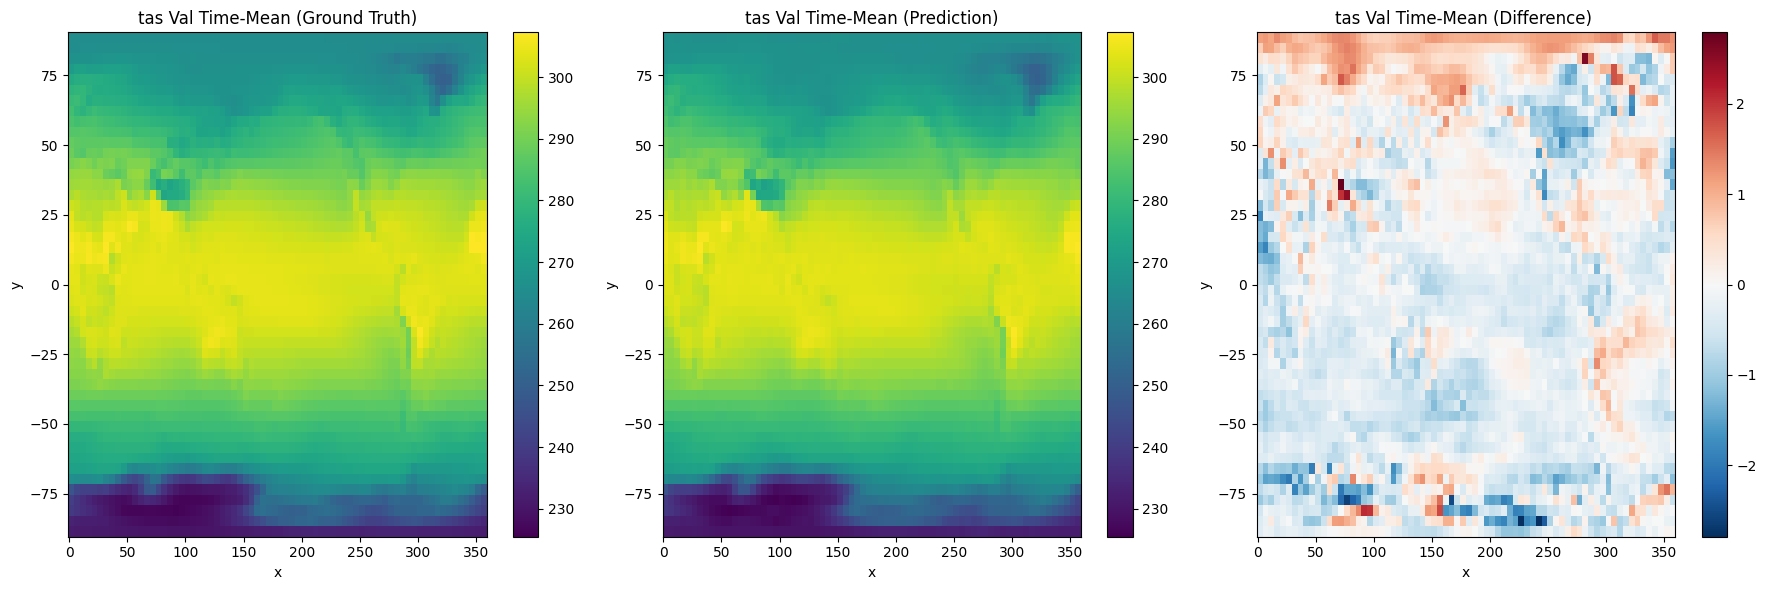

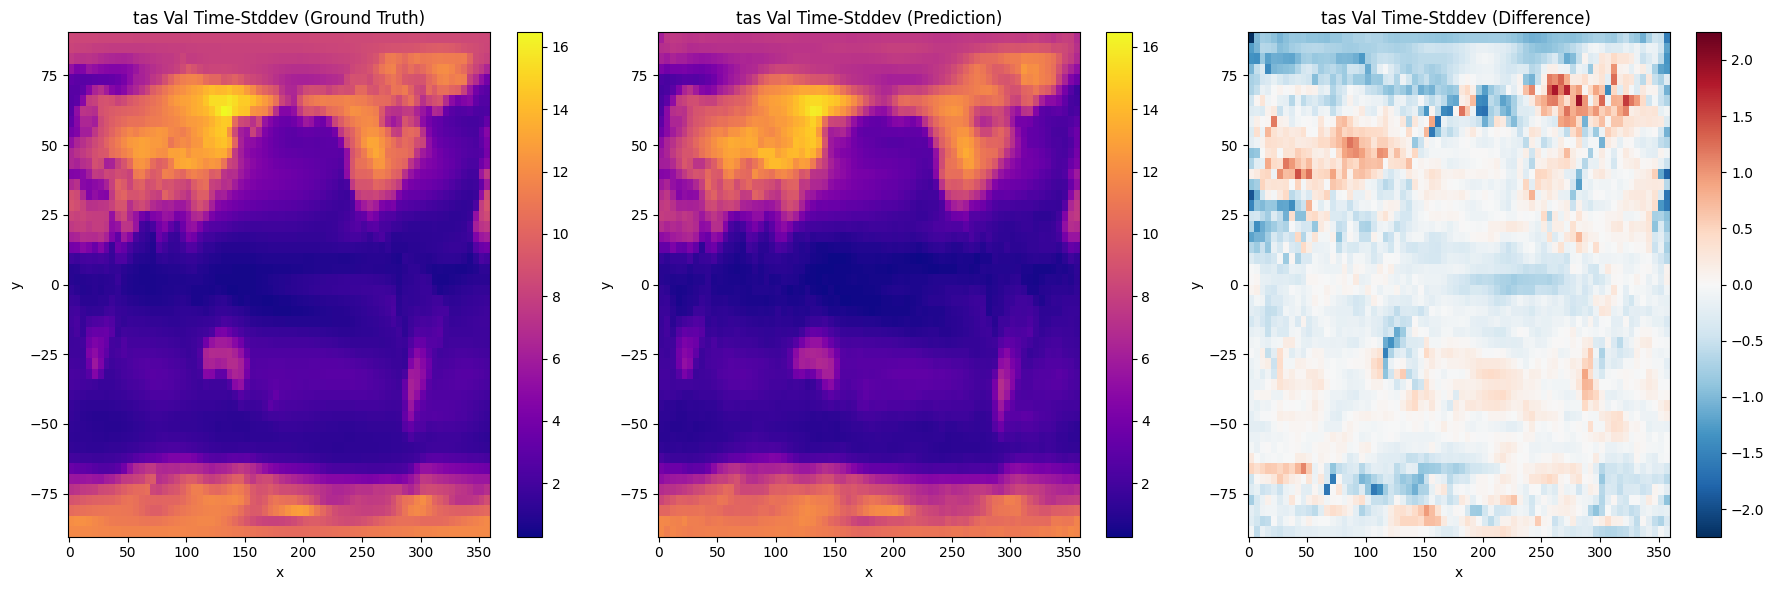

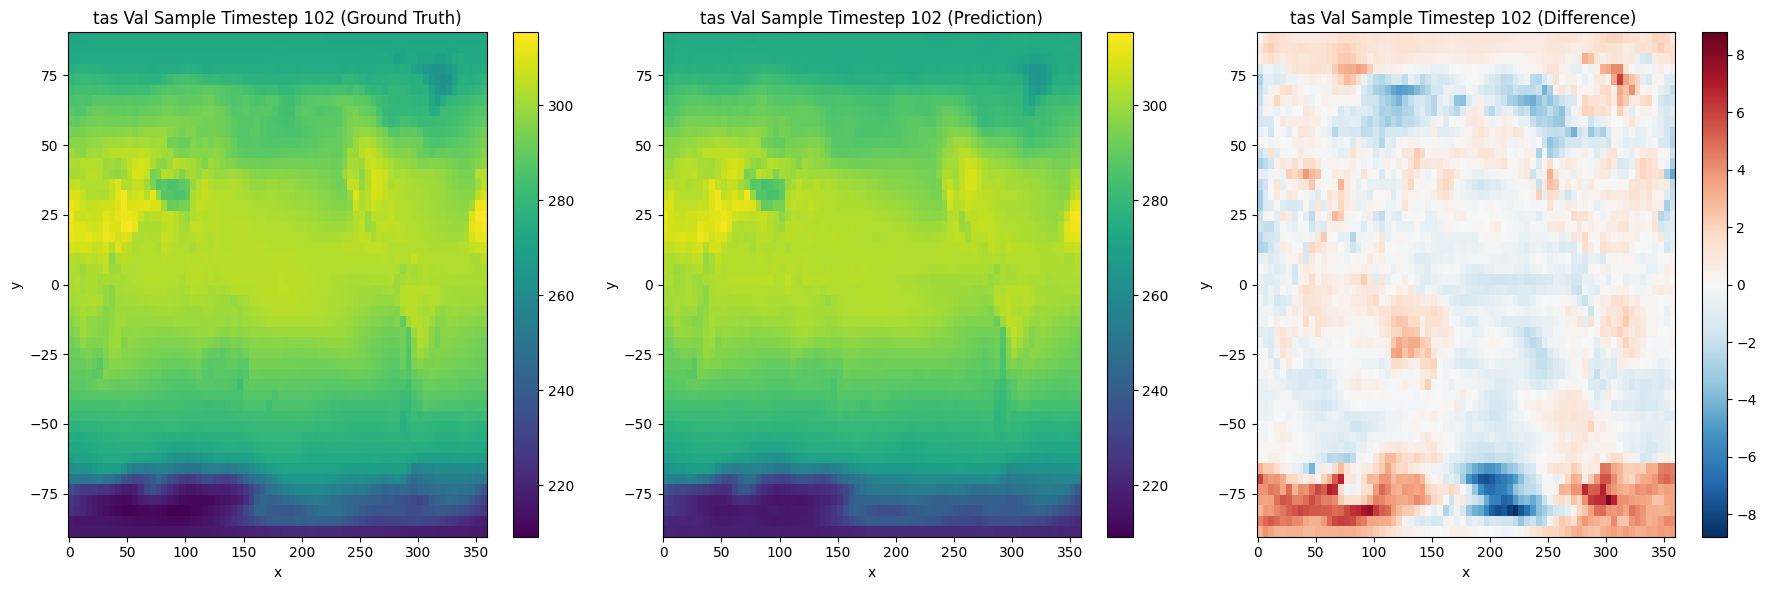

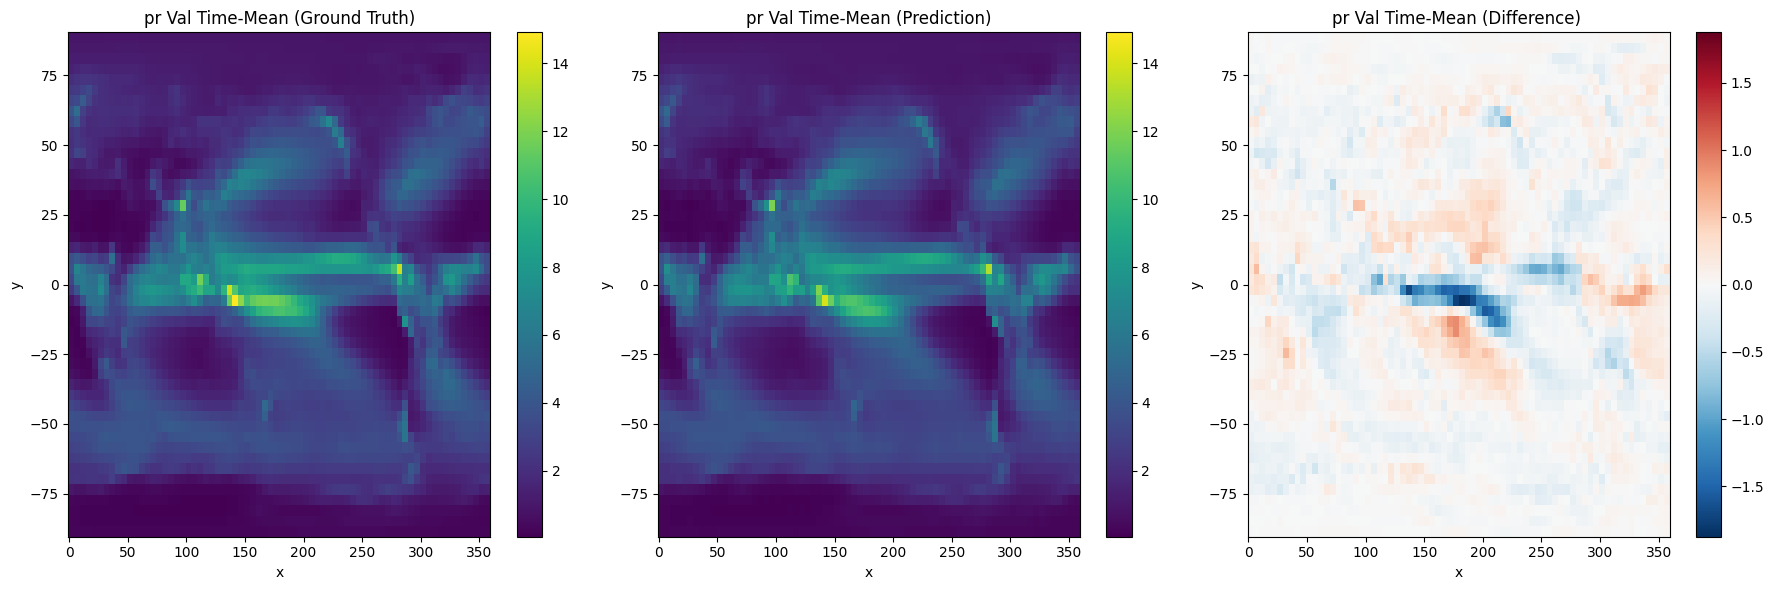

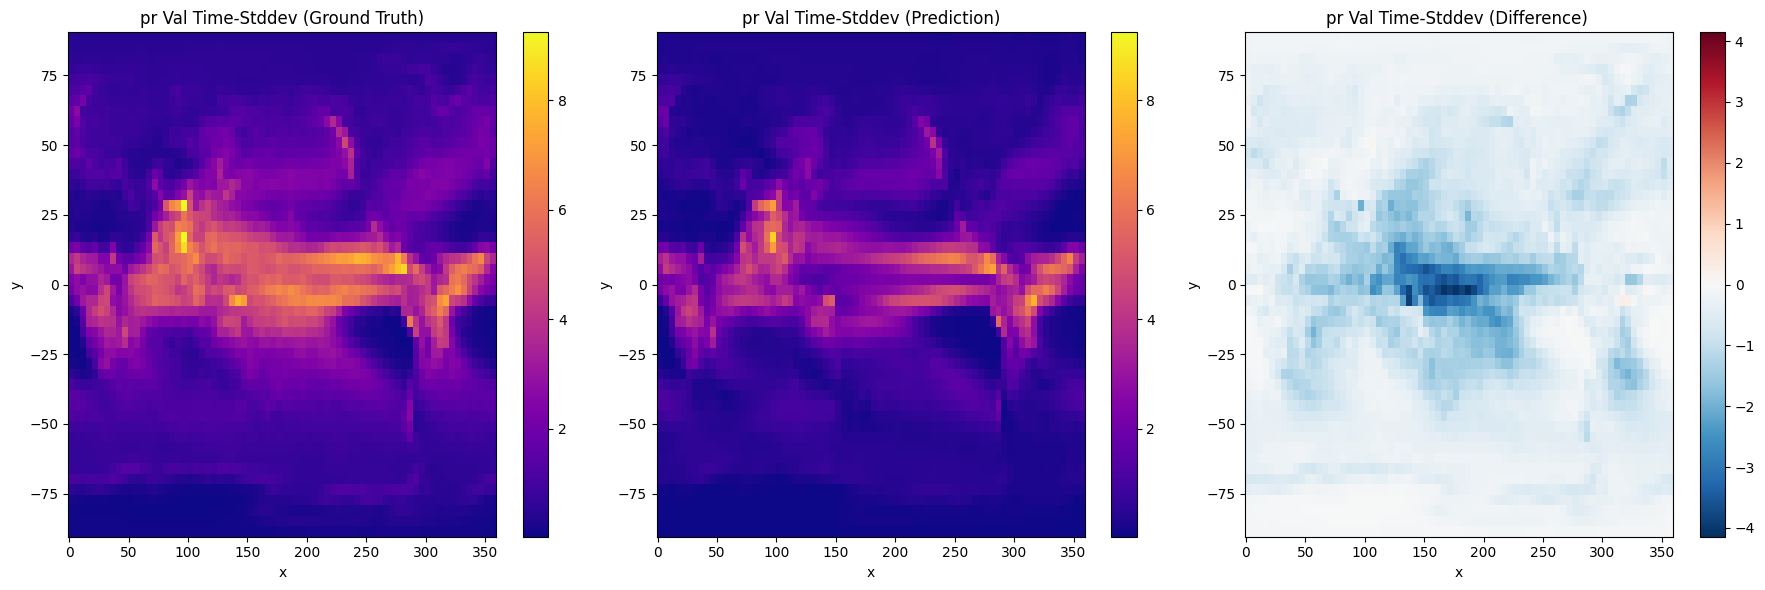

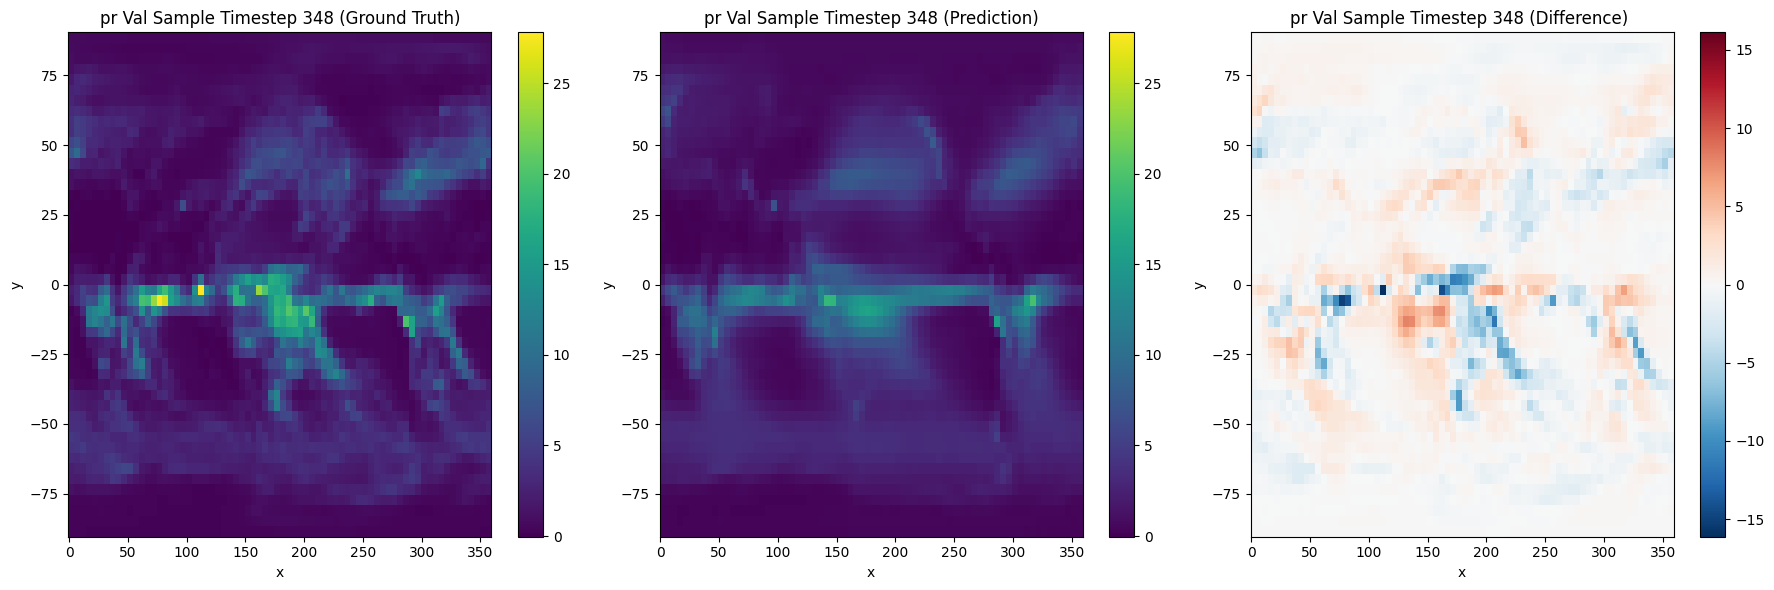

In [11]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`. 
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with 
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!
